In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Necessary Libraries

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Getting the data

In [ ]:
# get data
train_folder = '/content/drive/MyDrive/cvpr_proj/face dataset/train'
test_folder = '/content/drive/MyDrive/cvpr_proj/face dataset/test'
valid_folder = '/content/drive/MyDrive/cvpr_proj/face dataset/valid'

In [ ]:
train_images = []
train_labels = []
test_images = []
test_labels = []
valid_images = []
valid_labels = []

In [ ]:
for folder in os.listdir(train_folder):
    folder_path = os.path.join(train_folder, folder)
    label = 0 if folder == 'real' else 1  # label 0 for real images, 1 for deep fake images

    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (128, 128))  # resizing the image to match the input size of the CNN

        #convert to tensor
        tf_image = tf.convert_to_tensor(image)

        #functions for augmentation
        aug_lr_img = (tf.image.flip_left_right(tf_image))
        aug_ud_img = (tf.image.flip_up_down(tf_image))
        aug_90_img = (tf.image.rot90(tf_image, k=1))
        aug_brt_img = (tf.image.random_brightness(tf_image, max_delta=0.5))
        aug_cont_img = (tf.image.random_contrast(tf_image, 0.1, 0.5))
        aug_sat_img = (tf.image.random_saturation(tf_image, 5,10))

        #convert augmented tensor into numpy array
        ori_img = tf_image
        train_images.append(ori_img.numpy())
        train_images.append(aug_lr_img.numpy())
        train_images.append(aug_ud_img.numpy())
        train_images.append(aug_90_img.numpy())
        train_images.append(aug_brt_img.numpy())
        train_images.append(aug_cont_img.numpy())
        train_images.append(aug_sat_img.numpy())

        #add labels for the images
        for i in range(7):
          train_labels.append(label)


In [ ]:
for folder in os.listdir(test_folder):
    folder_path = os.path.join(test_folder, folder)
    label = 0 if folder == 'real' else 1  # label 0 for real images, 1 for deep fake images

    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (128, 128))  # resizing the image to match the input size of the CNN
        test_images.append(image)
        test_labels.append(label)

In [ ]:
valid_images = []
valid_labels = []

In [ ]:
for folder in os.listdir(valid_folder):
    folder_path = os.path.join(valid_folder, folder)
    label = 0 if folder == 'real' else 1  # label 0 for real images, 1 for deep fake images

    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (128, 128))  # resizing the image to match the input size of the CNN

        #convert to tensor
        tf_image = tf.convert_to_tensor(image)

        #functions for augmentation
        aug_lr_img = (tf.image.flip_left_right(tf_image))
        aug_ud_img = (tf.image.flip_up_down(tf_image))
        aug_90_img = (tf.image.rot90(tf_image, k=1))
        aug_brt_img = (tf.image.random_brightness(tf_image, max_delta=0.5))
        aug_cont_img = (tf.image.random_contrast(tf_image, 0.1, 0.5))
        aug_sat_img = (tf.image.random_saturation(tf_image, 5,10))

        #convert augmented tensor into numpy array
        ori_img = tf_image
        valid_images.append(ori_img.numpy())
        valid_images.append(aug_lr_img.numpy())
        valid_images.append(aug_ud_img.numpy())
        valid_images.append(aug_90_img.numpy())
        valid_images.append(aug_brt_img.numpy())
        valid_images.append(aug_cont_img.numpy())
        valid_images.append(aug_sat_img.numpy())

        #add labels for the images
        for i in range(7):
          valid_labels.append(label)

In [3]:
# custom dataset class for loading the images
class CustomDataset(Dataset):
    def __init__(self, images, ela_images, labels, transform=None):
        self.images = images
        self.ela_images = ela_images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        ela_image = self.ela_images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)
            ela_image = self.transform(ela_image)

        return image, ela_image, label

In [ ]:
# convert the lists to NumPy arrays
train_images = np.array(train_images, dtype='float32')
train_labels = np.array(train_labels)

In [ ]:
test_images = np.array(test_images, dtype='float32')
test_labels = np.array(test_labels)

In [ ]:
valid_images = np.array(valid_images, dtype='float32')
valid_labels = np.array(valid_labels)

# Pre-Processing

In [ ]:
# error level analysis (ELA)
def ela(image):
    temp_filename = 'temp.jpg'
    cv2.imwrite(temp_filename, image, [cv2.IMWRITE_JPEG_QUALITY, 90])
    temp_image = cv2.imread(temp_filename)
    temp_image = temp_image.astype(image.dtype)
    diff = cv2.absdiff(image, temp_image)
    ela_image = cv2.convertScaleAbs(diff, alpha=80, beta=-30)
    os.remove(temp_filename)
    return ela_image

train_ela = np.array([ela(image) for image in train_images])
test_ela = np.array([ela(image) for image in test_images])
valid_ela = np.array([ela(image) for image in valid_images])


# Preprocess the ELA images using PyTorch transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Create custom datasets for training and testing
train_dataset = CustomDataset(train_images, train_ela, train_labels, transform=transform)
test_dataset = CustomDataset(test_images, test_ela, test_labels, transform=transform)
valid_dataset = CustomDataset(valid_images, valid_ela, valid_labels, transform=transform)

In [ ]:
# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Model

In [4]:
import pickle
#Load the loaders
with open('/content/drive/MyDrive/HKBU/CVPR/data_loaders.pkl', 'rb') as f:
    train_loader, test_loader, valid_loader = pickle.load(f)

In [5]:
# # Load the pre-trained MobileNet model
# model = models.mobilenet_v2(pretrained=True)
# model.classifier[1] = nn.Linear(1280, 2)  # Replace the final fully connected layer for binary classification

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

In [6]:
import torch
import torch.nn as nn

In [17]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(0.2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout2d(0.2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.dropout2(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        x = self.flatten(x)

        return x


In [18]:
def build_model():
    model = CustomCNN()
    return model

In [19]:
from torchvision import models
from torchsummary import summary

In [20]:
model1 = build_model()
print(model1)

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.2, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (relu4): ReLU()
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [21]:
model2 = build_model()
print(model2)

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.2, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (relu4): ReLU()
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [22]:
class ConcatenatedModel(nn.Module):
    def __init__(self):
        super(ConcatenatedModel, self).__init__()
        self.original_branch = model1
        # self.original_branch.fc = nn.Linear(256, 128)  # for original images
        self.ela_branch = model2
        # self.ela_branch.fc = nn.Linear(256, 128)  # for ELA processed images
        self.fc = nn.Linear(18432, 2)  # final fully connected layer for classification
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)  # dropout probability of 0.5
        self.dropout2 = nn.Dropout(p=0.5)  # additional dropout layer

    def forward(self, original_images, ela_images):
        original_features = self.original_branch(original_images)
        original_features = self.relu(original_features)  # Apply ReLU activation
        original_features = self.dropout1(original_features)  # Apply Dropout
        ela_features = self.ela_branch(ela_images)
        ela_features = self.relu(ela_features)  # Apply ReLU activation
        ela_features = self.dropout1(ela_features)  # Apply Dropout
        concatenated_features = torch.cat((original_features, ela_features), dim=1)
        concatenated_features = self.dropout2(concatenated_features)  # Apply additional Dropout
        out = self.fc(concatenated_features)
        return out


model = ConcatenatedModel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ConcatenatedModel(
  (original_branch): CustomCNN(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout1): Dropout2d(p=0.2, inplace=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU()
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (relu3): ReLU()
    (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout2): Dropout2d(p=0.2, inplace=False)
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (relu4): ReLU()
    (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (ela_branch): CustomCNN(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu1): R

# Loss Function and Optimizer

In [23]:
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

In [24]:
# the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# training the model
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, ela_images, labels in train_loader:
        images = images.to(device)
        ela_images = ela_images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images, ela_images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    train_accuracy = correct / total
    train_loss = running_loss / len(train_loader)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, ela_images, labels in valid_loader:
            images = images.to(device)
            ela_images = ela_images.to(device)
            labels = labels.to(device)

            outputs = model(images, ela_images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    valid_accuracy = correct / total
    valid_loss = running_loss / len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Valid Loss: {valid_loss:.4f} - Valid Accuracy: {valid_accuracy:.4f}")

Epoch 1/15 - Train Loss: 1.6887 - Train Accuracy: 0.4971 - Valid Loss: 0.6996 - Valid Accuracy: 0.4403
Epoch 2/15 - Train Loss: 0.7214 - Train Accuracy: 0.5220 - Valid Loss: 0.6954 - Valid Accuracy: 0.4703
Epoch 3/15 - Train Loss: 0.6952 - Train Accuracy: 0.5445 - Valid Loss: 0.7026 - Valid Accuracy: 0.4620
Epoch 4/15 - Train Loss: 0.6871 - Train Accuracy: 0.5624 - Valid Loss: 0.6804 - Valid Accuracy: 0.5723
Epoch 5/15 - Train Loss: 0.6819 - Train Accuracy: 0.5742 - Valid Loss: 0.6605 - Valid Accuracy: 0.6165
Epoch 6/15 - Train Loss: 0.6753 - Train Accuracy: 0.5789 - Valid Loss: 0.6615 - Valid Accuracy: 0.5923
Epoch 7/15 - Train Loss: 0.6737 - Train Accuracy: 0.5878 - Valid Loss: 0.6839 - Valid Accuracy: 0.5464
Epoch 8/15 - Train Loss: 0.6705 - Train Accuracy: 0.5915 - Valid Loss: 0.6595 - Valid Accuracy: 0.5973
Epoch 9/15 - Train Loss: 0.6645 - Train Accuracy: 0.6061 - Valid Loss: 0.6528 - Valid Accuracy: 0.6132
Epoch 10/15 - Train Loss: 0.6628 - Train Accuracy: 0.6004 - Valid Loss: 0

# Evaluation

In [25]:
# evaluation of the model on the test set
model.eval()
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, ela_images, labels in test_loader:
        images = images.to(device)
        ela_images = ela_images.to(device)
        labels = labels.to(device)

        outputs = model(images, ela_images)
        _, predicted = torch.max(outputs.data, 1)

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Accuracy : %0.2f" % (accuracy*100),'%')
print("Precision: %0.2f" % (precision*100),'%')
print("Recall   :", recall)
print("F1-Score :", f1)

Accuracy : 62.23 %
Precision: 53.95 %
Recall   : 0.5829383886255924
F1-Score : 0.560364464692483


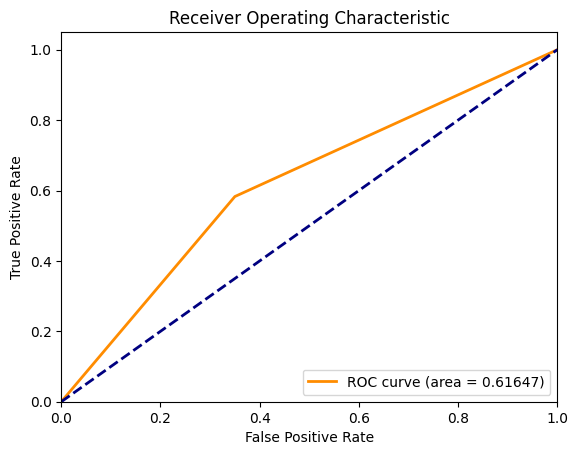

In [26]:
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

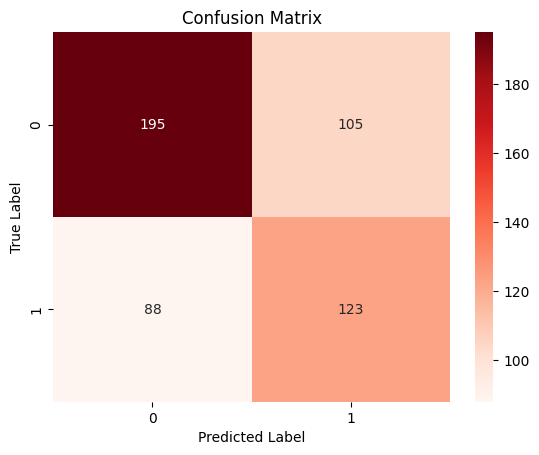

In [27]:
confusion = confusion_matrix(true_labels, predicted_labels)

plt.figure()
sns.heatmap(confusion, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

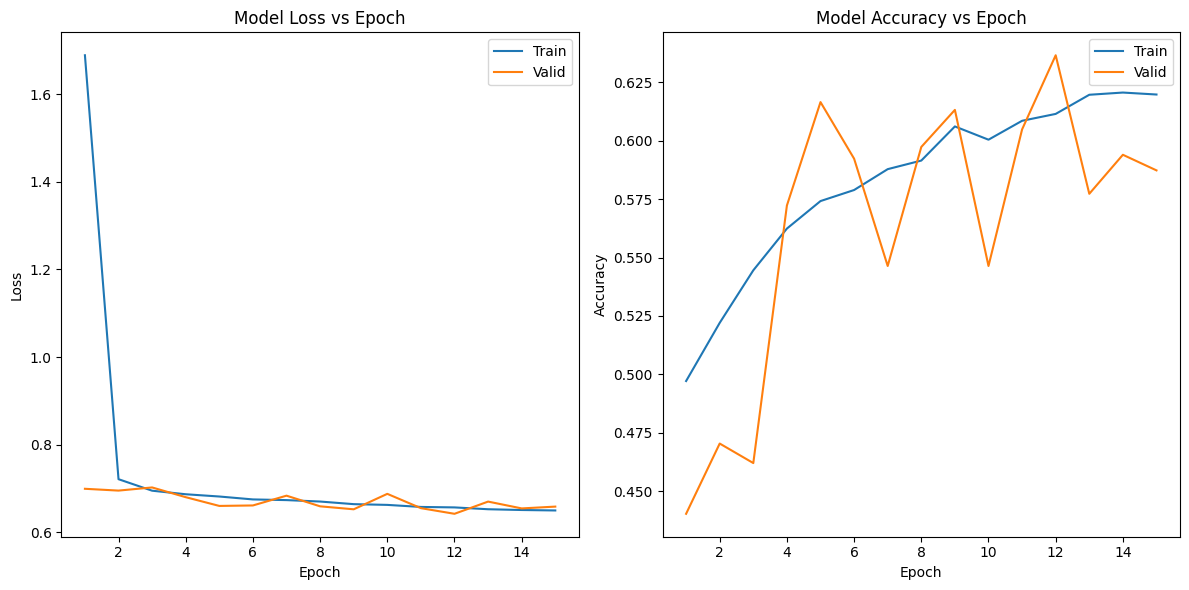

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# plot model loss vs epoch
axs[0].plot(range(1, num_epochs+1), train_losses, label='Train')
axs[0].plot(range(1, num_epochs+1), valid_losses, label='Valid')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Model Loss vs Epoch')
axs[0].legend()

# plot model accuracy vs epoch
axs[1].plot(range(1, num_epochs+1), train_accuracies, label='Train')
axs[1].plot(range(1, num_epochs+1), valid_accuracies, label='Valid')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Model Accuracy vs Epoch')
axs[1].legend()

plt.tight_layout()
plt.show()